In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from __future__ import unicode_literals
from IPython.core.display import display, HTML
import glob
from radical.entk import Profiler
import radical.analytics as ra
import radical.utils as ru
import radical.pilot as rp


pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

%matplotlib inline

/home/vivek/Research/tools/miniconda2/envs/ve-notebook/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:63: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


In [2]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-colorblind')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 1
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)    
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

In [3]:
# Generate task uids

def get_task_uids(num_pipelines):
    
    num_tasks = num_pipelines*7*1
    task_uids = []
    for t in range(num_tasks):
        task_uids.append('radical.entk.task.%04d'%t)

    return task_uids

In [16]:
# Get information from all the entk profiles

def get_entk_info(src):
    
    p = Profiler(src = src + '/../')
    
    task_uids = get_task_uids(pipelines)
    
    entk_total_task_dur = p.duration(task_uids, states=['SCHEDULING','DONE'])
    entk_task_exec_dur = p.duration(task_uids, states=['SUBMITTED','EXECUTED'])
    
    print 'EnTK total task duration: ', entk_total_task_dur
    print 'EnTK task execution duration: ', entk_task_exec_dur
    
    return entk_total_task_dur, entk_task_exec_dur
    

In [17]:
# Get information from all the rp profile files and json file
# returns 0,0 if no rp files are found

def get_rp_info(src):


    json_files = glob.glob('%s/*.json'%src)
    json_file = json_files[0]
    json      = ru.read_json(json_file)
    sid       = os.path.basename(json_file)[:-5]

    session = ra.Session(sid, 'radical.pilot', src=src)
    units = session.filter(etype='unit', inplace=False)

    exec_dur = units.duration([rp.AGENT_EXECUTING, rp.AGENT_STAGING_OUTPUT_PENDING])
    rp_dur = units.duration([rp.UMGR_SCHEDULING, rp.DONE])

    print exec_dur, rp_dur

    return rp_dur, exec_dur


In [21]:
# df = pd.DataFrame(columns=['EnTK overhead', 'RP overhead', 'Execution duration'])
df = pd.DataFrame(columns=['EnTK Management Overhead', 'Task Execution Time'])
df_rp = pd.DataFrame(columns=['TTR', 'TTE'])

pipelines_list = [65]

for pipelines in pipelines_list:
    
    src = glob.glob('./null_workload_{0}_replicas/rp.session*'.format(pipelines))
    src_cpy = list(src)
    print src
    for f in src:
        if f.split('.')[-1] == 'json':
            src_cpy.remove(f)

    src = src_cpy[0]
    print src
    ttr, tte = get_entk_info(src)
#     rp_dur, exec_dur = get_rp_info(src)
        
    df.loc[str(pipelines)] = [ttr-tte,tte]
    df_rp.loc[str(pipelines)] = [rp_dur,exec_dur]

[u'./null_workload_65_replicas/rp.session.two.jdakka.017462.0002.json', u'./null_workload_65_replicas/rp.session.two.jdakka.017462.0002']
./null_workload_65_replicas/rp.session.two.jdakka.017462.0002


IndexError: list index out of range

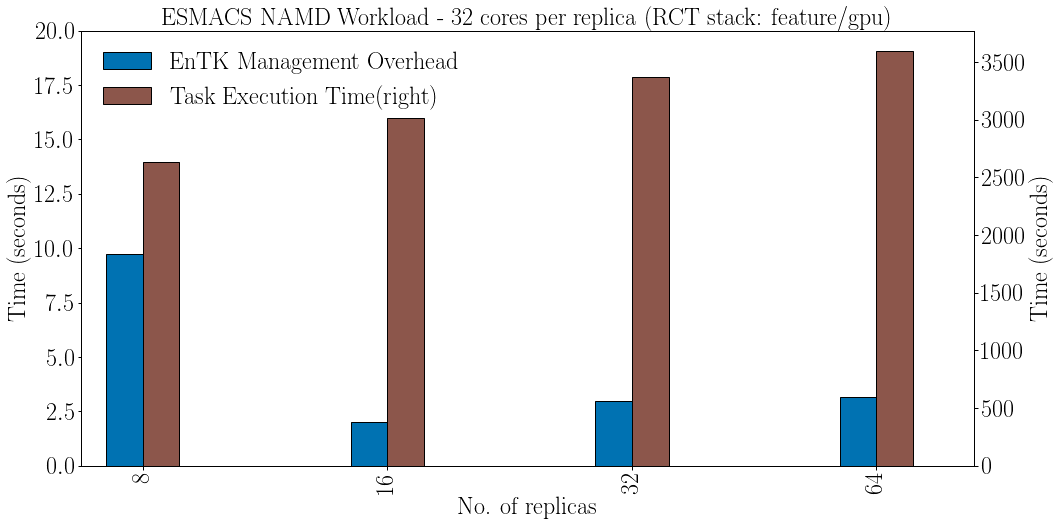

In [64]:
fig, ax = fig_setup()

width=0.15
ax = df.plot(kind='bar', 
             ax=ax,
             y=df.columns.drop('Task Execution Time').tolist(),
             fontsize=SIZE,
             width=width,
             position=1,
             title='ESMACS NAMD Workload - 32 cores per replica (RCT stack: feature/gpu)',
             legend=False)

ax2 = df['Task Execution Time'].plot(secondary_y=True, width=0.15, color=tableau20[10], legend=False, position=0, kind='bar')


ax.set_ylim(0,20)
ax.set_xlabel('No. of replicas', fontsize=SIZE)
ax.set_ylabel('Time (seconds)', fontsize=SIZE)
ax2.set_ylabel('Time (seconds)', fontsize=SIZE)
ax.set_title(ax.get_title(), fontsize=SIZE)

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
labels = l1 + [l2[0] + '(right)']
handles = h1 + h2
plt.legend(handles,labels,fontsize=SIZE, loc='upper left')

fig.savefig('./plots/esmacs_32_cpr_gpu_stack.pdf', dpi=100, bbox_inches='tight')
fig.savefig('./plots/esmacs_32_cpr_gpu_stack.png', dpi=100, bbox_inches='tight')

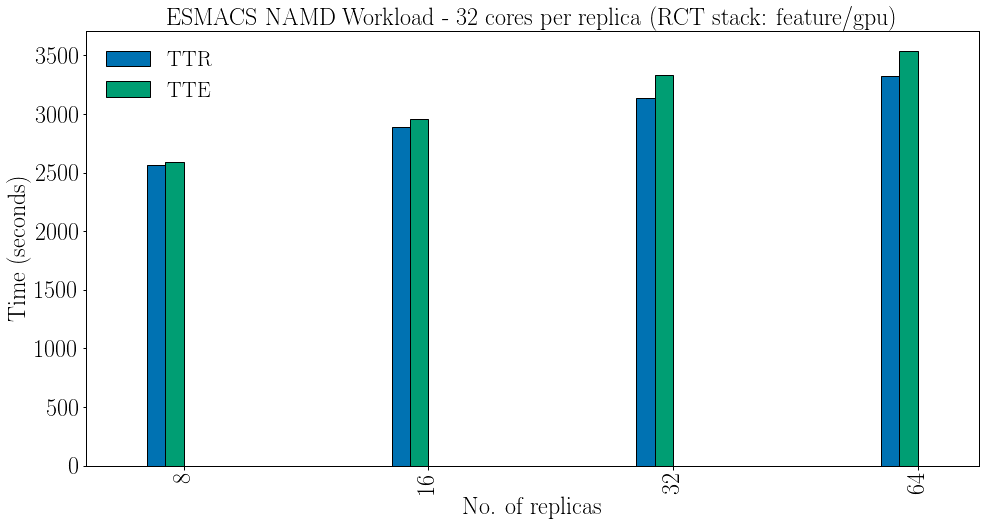

In [69]:
fig, ax = fig_setup()

width=0.15
ax = df_rp.plot(kind='bar', 
             ax=ax,
             fontsize=SIZE,
             width=width,
             position=1,
             title='ESMACS NAMD Workload - 32 cores per replica (RCT stack: feature/gpu)',
             legend=True)


ax.set_xlabel('No. of replicas', fontsize=SIZE)
ax.set_ylabel('Time (seconds)', fontsize=SIZE)
ax.set_title(ax.get_title(), fontsize=SIZE)

fig.savefig('./plots/rp_durations_esmacs_32_cpr_gpu_stack.pdf', dpi=100, bbox_inches='tight')
fig.savefig('./plots/rp_durations_esmacs_32_cpr_gpu_stack.png', dpi=100, bbox_inches='tight')

In [65]:
df_rp

,TTR,TTE
8,2640.2630,2630.519900
16,3014.1272,3012.130200
32,3370.5328,3367.552300
64,3594.4332,3591.268701
